## Portfolio Optimization & Sharpe Ratio

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import random
import warnings
import statsmodels.api as sm
import yfinance as yf
import numpy as np
import cvxpy as cp

warnings.filterwarnings('ignore')

c:\Users\Samneh\Desktop\QuantDay1-14\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading our Assets

gold = yf.download("GLD", start="2007-01-01", end="2023-12-31", multi_level_index=False)["Close"]

oil =  yf.download("USO", start="2007-01-01", end="2023-12-31", multi_level_index=False)["Close"]

spy =  yf.download("SPY", start="2007-01-01", end="2023-12-31", multi_level_index=False)["Close"]

apple = yf.download("AAPL", start="2007-01-01", end="2023-12-31", multi_level_index=False)["Close"]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# computing the log returns

gold_returns = np.log(gold/gold.shift(1))

oil_returns = np.log(oil/oil.shift(1))

spy_returns = np.log(spy/spy.shift(1))

apple_returns = np.log(apple/apple.shift(1))

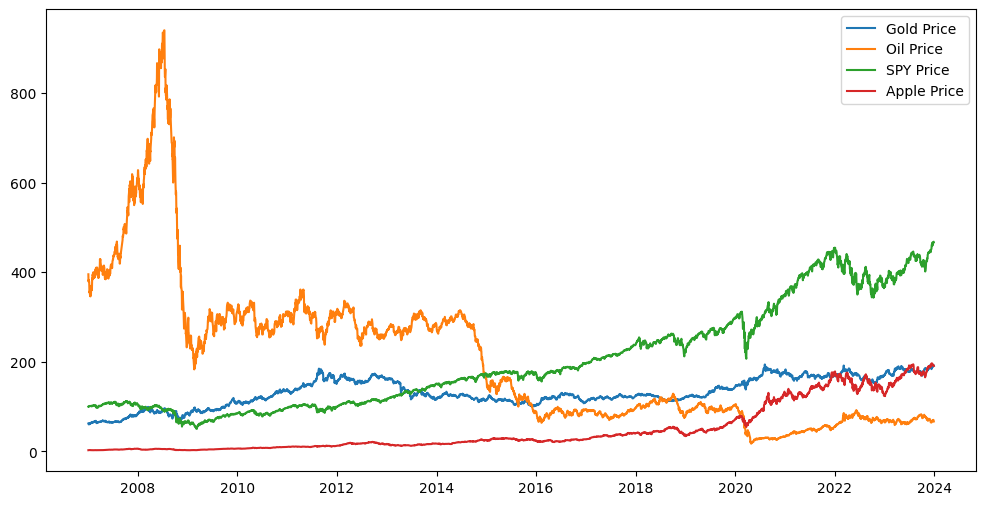

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(gold, label='Gold Price')
plt.plot(oil, label='Oil Price')
plt.plot(spy, label='SPY Price')
plt.plot(apple, label='Apple Price')
plt.legend()
plt.show()


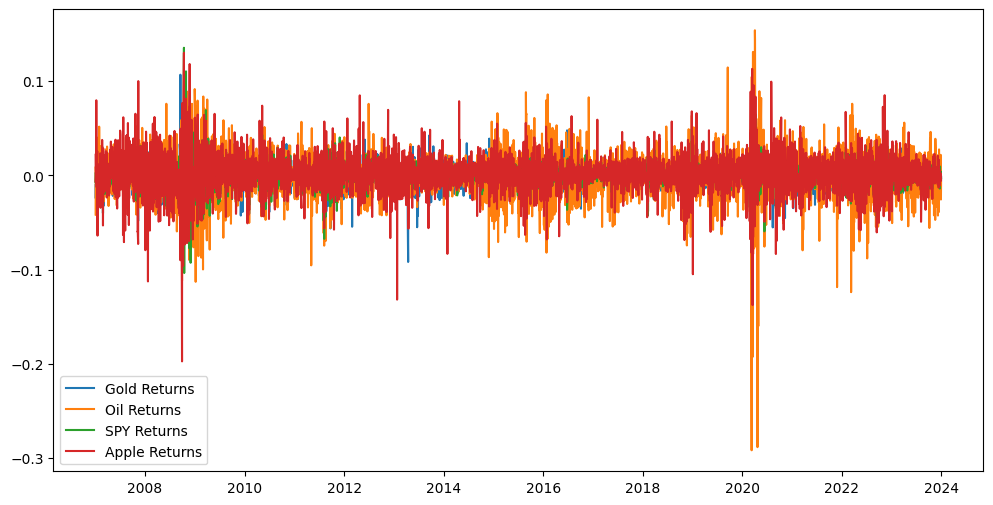

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(gold_returns, label='Gold Returns')
plt.plot(oil_returns, label='Oil Returns')
plt.plot(spy_returns, label='SPY Returns')
plt.plot(apple_returns, label='Apple Returns')
plt.legend()
plt.show()


In [6]:
df = pd.DataFrame({"Gold" : gold_returns, "Oil" : oil_returns, "SPY" : spy_returns, "Apple" : apple_returns}).dropna()

# daily covariance of log returns; annualize for use with annual expected returns
cov_matrix = df.cov() * 252

df.describe()

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4277 entries, 2007-01-04 to 2023-12-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gold    4277 non-null   float64
 1   Oil     4277 non-null   float64
 2   SPY     4277 non-null   float64
 3   Apple   4277 non-null   float64
dtypes: float64(4)
memory usage: 167.1 KB


,Gold,Oil,SPY,Apple
Date,,,,
2007-01-04,-0.010167,-0.041539,0.002120,0.021953
2007-01-05,-0.024299,0.009242,-0.008008,-0.007147
2007-01-08,0.005139,-0.007134,0.004614,0.004926
2007-01-09,0.006099,-0.004009,-0.000850,0.079800
2007-01-10,-0.004282,-0.041880,0.003326,0.046746


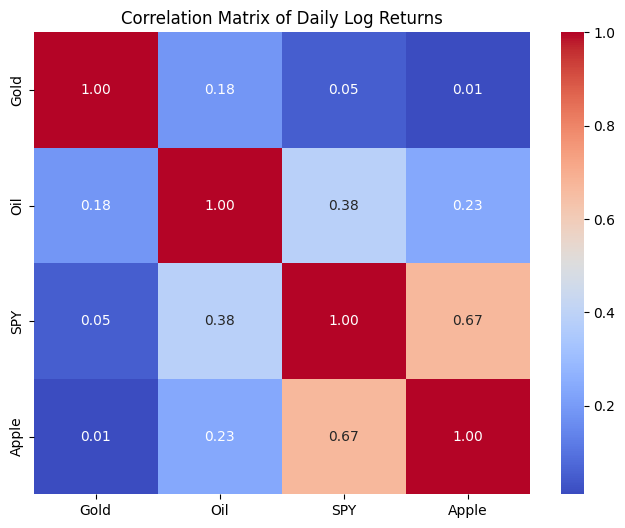

,Gold,Oil,SPY,Apple
Gold,0.030620,0.012271,0.001740,0.000563
Oil,0.012271,0.144289,0.029404,0.028340
SPY,0.001740,0.029404,0.040585,0.042812
Apple,0.000563,0.028340,0.042812,0.101268


In [7]:

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Daily Log Returns')
plt.show()
cov_matrix

In [8]:
# Annual log returns (sum daily logs within each year)
gold_ann_log = gold_returns.resample("Y").sum()
oil_ann_log = oil_returns.resample("Y").sum()
spy_ann_log = spy_returns.resample("Y").sum()
apple_ann_log = apple_returns.resample("Y").sum()

# Convert to annual arithmetic returns
gold_ann = np.exp(gold_ann_log) - 1
oil_ann = np.exp(oil_ann_log) - 1
spy_ann = np.exp(spy_ann_log) - 1
apple_ann = np.exp(apple_ann_log) - 1

# Historical expected annual return (arithmetic mean of annual returns)
er_hist_gold = gold_ann.mean()
er_hist_oil = oil_ann.mean()
er_hist_spy = spy_ann.mean()
er_hist_apple = apple_ann.mean()

# CAGR (Compound Annual Growth Rate) calculation
def calculate_cagr(start_value, end_value, num_years):
    return (end_value / start_value) ** (1 / num_years) - 1

num_years = len(gold_ann)
er_cagr_gold = calculate_cagr(gold.iloc[0], gold.iloc[-1], num_years)
er_cagr_oil = calculate_cagr(oil.iloc[0], oil.iloc[-1], num_years)
er_cagr_spy = calculate_cagr(spy.iloc[0], spy.iloc[-1], num_years)
er_cagr_apple = calculate_cagr(apple.iloc[0], apple.iloc[-1], num_years)


print(f"\nThe historical (arith) return of gold is {er_hist_gold:.4f}")
print(f"The historical (arith) return of oil is {er_hist_oil:.4f}")
print(f"The historical (arith) return of spy is {er_hist_spy:.4f}")
print(f"The historical (arith) return of apple is {er_hist_apple:.4f}")

print(f"\nThe CAGR (geom) of gold is {er_cagr_gold:.4f}")
print(f"The CAGR (geom) of oil is {er_cagr_oil:.4f}")
print(f"The CAGR (geom) of spy is {er_cagr_spy:.4f}")
print(f"The CAGR (geom) of apple is {er_cagr_apple:.4f}")


The historical (arith) return of gold is 0.0794
The historical (arith) return of oil is -0.0231
The historical (arith) return of spy is 0.1119
The historical (arith) return of apple is 0.3925

The CAGR (geom) of gold is 0.0682
The CAGR (geom) of oil is -0.0994
The CAGR (geom) of spy is 0.0948
The CAGR (geom) of apple is 0.2900


In [9]:
#CAPM

# rf = 0.0434 # Risk free rate
# rm = 0.09 # Market return (S&P 500)

# # These values are from Yahoo Finance/ Generated by AI 
# beta_gold = 0.38
# beta_oil = 0.7
# beta_spy = 1.0
# beta_apple = 1.2


# # Following the CAPM formula, not really used in Quantitative Finance, but it's a good way to get the expected return of the portfolio
# er_gold = rf + beta_gold * (rm - rf)
# er_oil = rf + beta_oil * (rm - rf)
# er_spy = rf + beta_spy * (rm - rf)
# er_apple = rf + beta_apple * (rm - rf)

# print(f"The expected return of gold is {er_gold}")
# print(f"The expected return of oil is {er_oil}")
# print(f"The expected return of spy is {er_spy}")
# print(f"The expected return of apple is {er_apple}")

# er = [er_gold, er_oil, er_spy, er_apple]
# n= len(er)


def expected_returns(rf=0.0434, rm=0.09, beta=None, hist_ret=None, cagr_ret=None, type="invalid"):
    if type == "CAPM":
        beta = np.asarray(beta)
        return rf + beta * (rm - rf)
    elif type == "Historical":
        return np.asarray(hist_ret)
    elif type == "CAGR":
        return np.asarray(cagr_ret)
    else:
        raise ValueError("Invalid type")

In [ ]:
# Fetched online with help of AI
betas = [0.38, 0.7, 1.0, 1.2]

# CAPM expected annual arithmetic returns
er_capm_arith = expected_returns(rf=0.0434, rm=0.09, beta=betas, type="CAPM")
er_capm = np.log1p(er_capm_arith)

# Historical arithmetic mean annual returns
er_hist = expected_returns(hist_ret=[er_hist_gold, er_hist_oil, er_hist_spy, er_hist_apple], type="Historical")

# CAGR geometric mean annual returns
er_cagr = expected_returns(cagr_ret=[er_cagr_gold, er_cagr_oil, er_cagr_spy, er_cagr_apple], type="CAGR")

In [11]:
rf = 0.0434
def portfolio_stats(weights, er, cov, rf):
    er = np.asarray(er)
    weights = np.asarray(weights)
    port_return = float(weights @ er)
    port_vol = float(np.sqrt(weights.T @ cov @ weights))
    # Handle potential division by zero if volatility is zero
    sharpe_ratio = (port_return - rf) / port_vol if port_vol > 0 else 0
    return port_return, port_vol, sharpe_ratio


In [12]:
# --- Minimum Variance Portfolio Optimization ---
w = cp.Variable(4)
objective = cp.Minimize(cp.quad_form(w, cov_matrix)) # Using cp.quad_form is standard
constraints = [cp.sum(w) == 1, w >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()

w_mvp = None
if problem.status == 'optimal':
    w_mvp = w.value
    print(f"\nThe optimal weights are: {w_mvp}")
    print(f"The minimum variance (annual variance) is: {problem.value:.4f}")
    print(f"The minimum volatility (annual st. dev.) is: {np.sqrt(problem.value):.4f}")

    # Calculate portfolio statistics with the optimal weights
    mvp_return_hist, mvp_vol_hist, mvp_sharpe_hist = portfolio_stats(w_mvp, er_hist, cov_matrix, rf)
    mvp_return_capm, mvp_vol_capm, mvp_sharpe_capm = portfolio_stats(w_mvp, er_capm, cov_matrix, rf)
    mvp_return_cagr, mvp_vol_cagr, mvp_sharpe_cagr = portfolio_stats(w_mvp, er_cagr, cov_matrix, rf)

    print("\n--- Minimum Variance Portfolio Stats ---")
    print(f"Historical ER -> Return: {mvp_return_hist:.4f}, Vol: {mvp_vol_hist:.4f}, Sharpe: {mvp_sharpe_hist:.4f}")
    print(f"CAPM ER -> Return: {mvp_return_capm:.4f}, Vol: {mvp_vol_capm:.4f}, Sharpe: {mvp_sharpe_capm:.4f}")
    print(f"CAGR ER -> Return: {mvp_return_cagr:.4f}, Vol: {mvp_vol_cagr:.4f}, Sharpe: {mvp_sharpe_cagr:.4f}")
else:
    print("\nOptimal solution not found.")


The optimal weights are: [5.73566864e-01 4.03244340e-24 4.26433136e-01 1.82967320e-23]
The minimum variance (annual variance) is: 0.0183
The minimum volatility (annual st. dev.) is: 0.1353

--- Minimum Variance Portfolio Stats ---
Historical ER -> Return: 0.0933, Vol: 0.1353, Sharpe: 0.3685
CAPM ER -> Return: 0.0734, Vol: 0.1353, Sharpe: 0.2219
CAGR ER -> Return: 0.0796, Vol: 0.1353, Sharpe: 0.2673


In [13]:

def solve_max_sharpe(er, cov, rf):
    """
    Solves the maximum Sharpe ratio portfolio optimization problem, since inputting it mathematically is not possible, due to CVXPY's limitations, we aim to make it convex and solve,
    the way we do this is adding a scaling factor to the weights, and then dividing the weights by the scaling factor to get the real weights, and adding a constraint that the numerator of the sharpe ratio is 1,
    this minimizes the volatility in the transformed space, and then we divide the weights by the scaling factor to get the real weights.
    """
    n = len(er)
    # Use y for scaled weights, k for the scaling factor
    y = cp.Variable(n)
    k = cp.Variable()

    # The objective is to minimize volatility in the transformed space
    # This is equivalent to maximizing the Sharpe Ratio
    objective = cp.Minimize(cp.quad_form(y, cov))

    # Constraints are also transformed
    constraints = [
        er @ y - rf * k == 1, # The numerator of the Sharpe ratio is set to 1
        cp.sum(y) == k,       # The sum of scaled weights equals the scaling factor
        k >= 0,               # Scaling factor must be non-negative
        y >= 0                # Weights must be non-negative (long only)
    ]

    problem = cp.Problem(objective, constraints)
    # Use a robust solver like SCS if the default has issues
    problem.solve(solver=cp.SCS)

    if problem.status == 'optimal' or problem.status == 'optimal_inaccurate':
        # To get the real weights, divide the scaled weights by the scaling factor
        w_optimal = y.value / k.value
        return w_optimal
    else:
        print("Optimal solution not found.")
        return np.full(n, np.nan)


# --- Solve for each expected return scenario ---
w_sharpe_hist = solve_max_sharpe(er_hist, cov_matrix, rf)
w_sharpe_capm = solve_max_sharpe(er_capm, cov_matrix, rf)
w_sharpe_cagr = solve_max_sharpe(er_cagr, cov_matrix, rf)


# --- Calculate and print the results ---
sharpe_return_hist, sharpe_vol_hist, sharpe_ratio_hist = portfolio_stats(w_sharpe_hist, er_hist, cov_matrix, rf)
sharpe_return_capm, sharpe_vol_capm, sharpe_ratio_capm = portfolio_stats(w_sharpe_capm, er_capm, cov_matrix, rf)
sharpe_return_cagr, sharpe_vol_cagr, sharpe_ratio_cagr = portfolio_stats(w_sharpe_cagr, er_cagr, cov_matrix, rf)

print("--- Max Sharpe Portfolio Results ---")
print("\nMax Sharpe weights (Historical):", np.round(w_sharpe_hist, 4))
print("Max Sharpe weights (CAPM):", np.round(w_sharpe_capm, 4))
print("Max Sharpe weights (CAGR):", np.round(w_sharpe_cagr, 4))


print(f"\nMax Sharpe (Historical) -> Return: {sharpe_return_hist:.4f}, Vol: {sharpe_vol_hist:.4f}, Sharpe: {sharpe_ratio_hist:.4f}")
print(f"Max Sharpe (CAPM) -> Return: {sharpe_return_capm:.4f}, Vol: {sharpe_vol_capm:.4f}, Sharpe: {sharpe_ratio_capm:.4f}")
print(f"Max Sharpe (CAGR) -> Return: {sharpe_return_cagr:.4f}, Vol: {sharpe_vol_cagr:.4f}, Sharpe: {sharpe_ratio_cagr:.4f}")


--- Max Sharpe Portfolio Results ---

Max Sharpe weights (Historical): [0.2442 0.     0.     0.7558]
Max Sharpe weights (CAPM): [ 0.3173 -0.      0.602   0.0808]
Max Sharpe weights (CAGR): [0.2394 0.     0.     0.7606]

Max Sharpe (Historical) -> Return: 0.3161, Vol: 0.2447, Sharpe: 1.1142
Max Sharpe (CAPM) -> Return: 0.0816, Vol: 0.1527, Sharpe: 0.2501
Max Sharpe (CAGR) -> Return: 0.2369, Vol: 0.2461, Sharpe: 0.7865


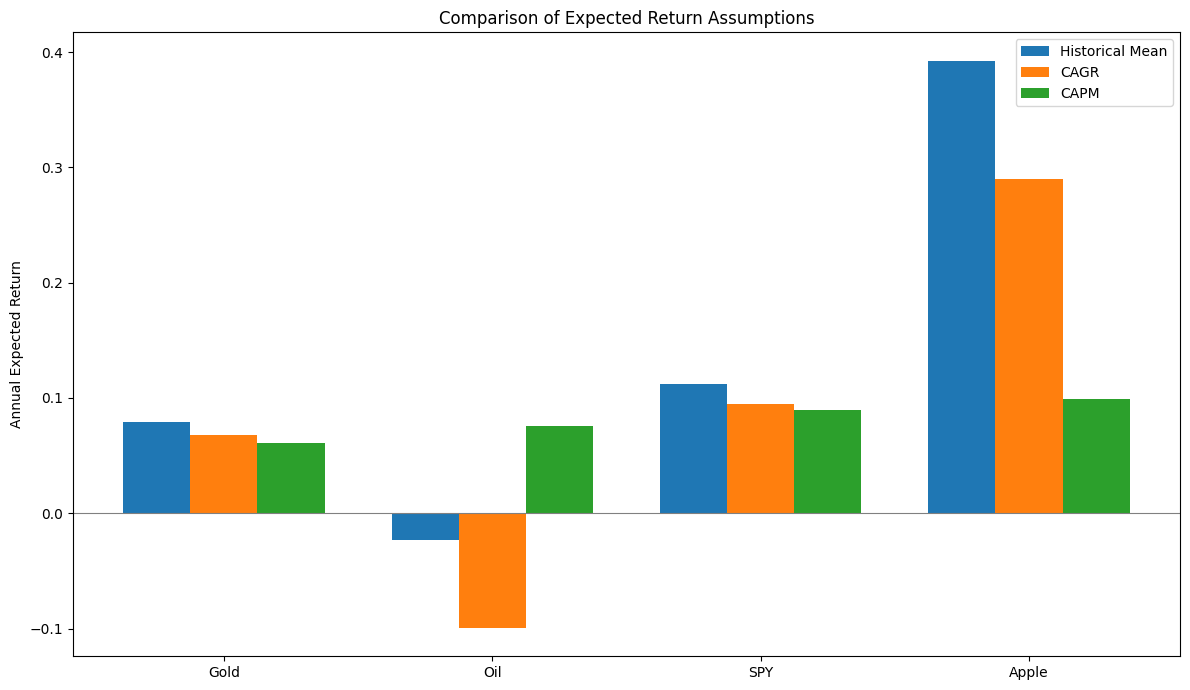

In [14]:
assets = ['Gold', 'Oil', 'SPY', 'Apple']
x = np.arange(len(assets))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width, er_hist, width, label='Historical Mean')
rects2 = ax.bar(x, er_cagr, width, label='CAGR')
rects3 = ax.bar(x + width, er_capm, width, label='CAPM')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Annual Expected Return')
ax.set_title('Comparison of Expected Return Assumptions')
ax.set_xticks(x)
ax.set_xticklabels(assets)
ax.legend()
ax.axhline(0, color='grey', linewidth=0.8) # Add a zero line

fig.tight_layout()
plt.show()

In [15]:
import plotly.io as pio
import plotly.graph_objects as go

# --- Recalculate the key portfolio stats for clarity
mvp_return_hist, mvp_vol_hist, _ = portfolio_stats(w_mvp, er_hist, cov_matrix, rf)
sharpe_return_hist, sharpe_vol_hist, _ = portfolio_stats(w_sharpe_hist, er_hist, cov_matrix, rf)
assets = ['Gold', 'Oil', 'SPY', 'Apple']

# --- Helper function to solve for the portfolio with a target return
# (Modified to return weights for the hover-text)
def solve_for_target_return(er, cov, target_return):
    n = len(er)
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, cov))
    constraints = [cp.sum(w) == 1, er @ w == target_return, w >= 0]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    # Check if a solution was found
    if problem.status == 'optimal' or problem.status == 'optimal_inaccurate':
        return (np.sqrt(problem.value), w.value)
    else:
        # Return NaN if no optimal portfolio exists for this return level
        return (np.nan, np.full(n, np.nan))

# --- Generate the points for the TRUE Efficient Frontier
# 1. Start from the MVP's return and go up to the max single-asset return
# 2. This removes the inefficient bottom half of the curve.
target_returns = np.linspace(mvp_return_hist, max(er_hist)*1.05, 75)
frontier_vols = []
frontier_weights = []

for r in target_returns:
    vol, weights = solve_for_target_return(er_hist, cov_matrix, r)
    frontier_vols.append(vol)
    frontier_weights.append(weights)
    
# --- Create the interactive plot with Plotly
fig = go.Figure()

# Add the Efficient Frontier line
fig.add_trace(go.Scatter(
    x=frontier_vols, y=target_returns,
    mode='lines',
    name='Efficient Frontier'
))

# Create the hover text for each point on the frontier
hover_texts = []
for weights in frontier_weights:
    text = ""
    # Ensure weights is a valid array before formatting
    if weights is not None and not np.isnan(weights).any():
        text += f"<b>Return:</b> {target_returns[len(hover_texts)]:.3f}<br>"
        text += f"<b>Volatility:</b> {frontier_vols[len(hover_texts)]:.3f}<br><br>"
        for i, asset in enumerate(assets):
            text += f"<b>{asset}:</b> {weights[i]:.2%}<br>"
    hover_texts.append(text)

# Add the invisible scatter points for the hover-over functionality
fig.add_trace(go.Scatter(
    x=frontier_vols, y=target_returns,
    mode='markers',
    marker=dict(color='rgba(0,0,0,0)'), # Make markers invisible
    hoverinfo='text',
    hovertext=hover_texts,
    name='Portfolios'
))

# Add the Minimum Variance Portfolio (MVP)
fig.add_trace(go.Scatter(
    x=[mvp_vol_hist], y=[mvp_return_hist],
    mode='markers',
    marker=dict(symbol='star', color='red', size=15),
    name='Min Variance Portfolio (MVP)'
))

# Add the Max Sharpe Portfolio
fig.add_trace(go.Scatter(
    x=[sharpe_vol_hist], y=[sharpe_return_hist],
    mode='markers',
    marker=dict(symbol='star', color='green', size=15),
    name='Max Sharpe Portfolio'
))

# Update layout for a professional look
fig.update_layout(
    title='Interactive Efficient Frontier',
    xaxis_title='Volatility (Standard Deviation)',
    yaxis_title='Expected Return',
    yaxis_tickformat='.1%',
    xaxis_tickformat='.1%',
    legend_title="Portfolio",
    template='plotly_white'
)

pio.renderers.default = "vscode"  # or "vscode" if you're in VS Code

fig.show()